In [41]:
import os, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import random as tf_random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
FILE_PATH = "../data/processed/data_processed_v2_NoAcum_Total.csv"
LOOKBACK = 16         
HORIZON = 1
TARGET_ENTITY = None           
TEST_WEEKS = 52       
EPOCHS = 100
BATCH_SIZE = 32
UNITS = 64
DROPOUT = 0.2
SEED = 42

np.random.seed(SEED)
tf_random.set_seed(SEED)

In [43]:
df = pd.read_csv(FILE_PATH)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date", "total_cases"])

if TARGET_ENTITY:
    s = (df.loc[df["Entity"] == TARGET_ENTITY, ["Date", "total_cases"]]
           .groupby("Date", as_index=True)["total_cases"].sum()
           .sort_index())
else:
    s = (df.groupby("Date", as_index=True)["total_cases"].sum()
           .sort_index())

# enforce weekly continuity (fill gaps with 0)
freq_guess = "W-MON"
s = s.asfreq(freq_guess).fillna(0.0).astype("float32")

values = s.values.reshape(-1, 1).astype("float32")
n = len(values)
train_size = max(LOOKBACK + HORIZON, n - TEST_WEEKS)
train_size = min(train_size, n)  # guard

scaler = MinMaxScaler()
scaled = np.zeros_like(values, dtype=np.float32)
scaled[:train_size] = scaler.fit_transform(values[:train_size])
scaled[train_size:] = scaler.transform(values[train_size:])


def make_xy(arr, lookback, horizon=1):
    X, y, y_idx = [], [], []
    for t in range(lookback, len(arr)-horizon+1):
        X.append(arr[t-lookback:t, 0])
        y.append(arr[t + horizon - 1, 0])
        y_idx.append(t + horizon - 1)
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)
    y_idx = np.asarray(y_idx, dtype=int)
    return X, y, y_idx


X_all, y_all, idx_all = make_xy(scaled, LOOKBACK, HORIZON)
mask_train = idx_all < train_size
mask_test = ~mask_train

X_train = X_all[mask_train][..., None]  # shape: (N, lookback, 1)
y_train = y_all[mask_train]
X_test = X_all[mask_test][..., None]
y_test = y_all[mask_test]
test_target_idx = idx_all[mask_test]

# sanity guards
assert len(X_train) > 0 and len(
    X_test) > 0, "Check TEST_WEEKS / LOOKBACK split sizes."

In [44]:
model = Sequential([
    LSTM(UNITS, input_shape=(LOOKBACK, 1)),
    Dropout(DROPOUT),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
es = EarlyStopping(monitor="val_loss", patience=8,
                   restore_best_weights=True, mode="min")
hist = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1385 - val_loss: 0.0069
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 - val_loss: 0.0037
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 3.3878e-04
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 4.1155e-04
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 6.9813e-05
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 1.2756e-04
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 2.8665e-05
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 5.4185e-05
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 5.3302e-05
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 1.6370e-05
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 1.6784e-04
Epoch 12/100
15/15 ━━━━━━━

In [45]:
y_pred_scaled = model.predict(X_test, verbose=0).reshape(-1)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

mae = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
err = np.abs(y_true - y_pred)

# MAPE over non-zero actuals only (common robust approach when zeros exist)
nonzero_mask = np.abs(y_true) > 0
if nonzero_mask.any():
    mape = (np.mean((err[nonzero_mask]) /
            np.abs(y_true[nonzero_mask])) * 100.0)
    mape_info = f"MAPE (non-zero actuals, n={nonzero_mask.sum()}/{len(y_true)}): {mape:.2f}%"
else:
    mape = np.nan
    mape_info = "MAPE not computed (all actuals are zero in test window)."


print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(mape_info)

MAE: 9.9053
RMSE: 13.8417
MAPE (non-zero actuals, n=51/52): 22.19%


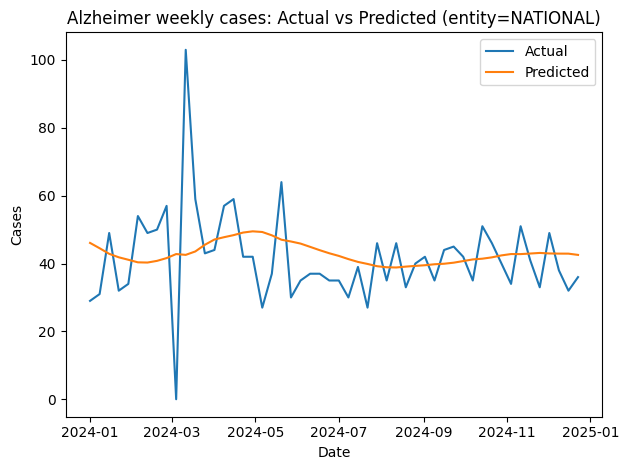

In [46]:
dates_test = s.index[test_target_idx]
plt.figure()
plt.plot(dates_test, y_true, label="Actual")
plt.plot(dates_test, y_pred, label="Predicted")
plt.title(f"Alzheimer weekly cases: Actual vs Predicted (entity={TARGET_ENTITY or 'NATIONAL'})")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.tight_layout()
plt.show()